## Adding utility function to return RGB image from BGR image 

In [1]:
import cv2
def get_mp_image( cv2Image):
    b,g,r = cv2.split( cv2Image )
    mp_image = cv2.merge([r,g,b])
    return mp_image

In [2]:
#initialize
DIST_COEFF = None
DIST_MATRIX = None
PERSPECTIVE_MATRIX = None
INV_PERSPECTIVE_MATRIX = None

## Camera Calibration 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

#function to get calibration matrix, distortion coefficients by using cv2.calibrateCamera on the supplied image
def calibrate_camera(img, dest_file):
    plt.figure(figsize=(10,10))
    objpoints=[]
    imgpoints=[]

    objp=np.zeros((9*6,3),dtype=np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #find chessboard corners
    ret, corners = cv2.findChessboardCorners( gray,(9,6),None)
    #if findChessboardCorners is successful
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        #draw chessboard corners
        cv2.drawChessboardCorners( gray, (9,6), corners, ret )
        #show original image
        plt.subplot(2,1,1)
        plt.imshow(img)
        
        #calibrate the camera and get the calibration matrix, distortion coefficients, rotational & translational vectors
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undstrt_img = cv2.undistort(img, mtx, dist, None, mtx)
        
#         src_points = np.float32([corners[0], corners[8], corners[-1], corners[-9]])        
#         offset=100
#         dest_points = np.float32([[offset,offset], [img.shape[1]-offset,offset],
#                 [img.shape[1]-offset,img.shape[0]-offset], [offset,img.shape[0]-offset]])        
#         M = cv2.getPerspectiveTransform(src_points,dest_points)
#         warped = cv2.warpPerspective(undstrt_img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )

        plt.subplot(2,1,2)
        #show undistorted image
        plt.imshow(undstrt_img)
        cv2.imwrite(dest_file, undstrt_img)
        print('Output Image saved to',dest_file)
    plt.show()
    #returning the calibration matrix, distortion coefficients
    return dist,mtx

### Test calibrate_camera function, and get DIST_COEFF, DIST_MATRIX

Output Image saved to ./output_images/calibration2.jpg


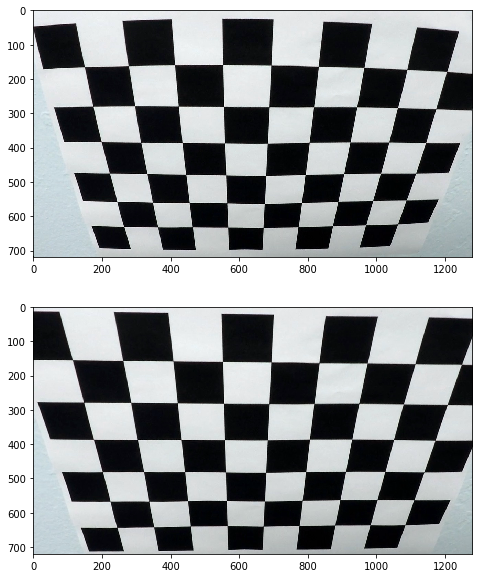

In [4]:
#read image from file
image = cv2.imread('./camera_cal/calibration2.jpg')
#get calibration matrix, distortion coefficients
DIST_COEFF, DIST_MATRIX = calibrate_camera(image,'./output_images/calibration2.jpg')
    
    

## Perspective Transform 

In [5]:
import cv2
import matplotlib.pyplot as plt

#apply perspective transform
def apply_perspective( img ):
    img = cv2.undistort(img, DIST_MATRIX, DIST_COEFF, None, DIST_MATRIX)
    src_points = np.float32([[572,460],  [708,460], [1060,680], [220,680]])
    bottom_left = [280,720] 
    bottom_right = [1000, 720]
    top_left = [280, 1]
    top_right = [1000, 1]  
    offset=100
    dest_points = np.float32([top_left, top_right, bottom_right, bottom_left])        
    M = cv2.getPerspectiveTransform(src_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,src_points)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )
    return M, warped, Minv

### Test apply_perspective function, and get PERSPECTIVE_MATRIX, INV_PERSPECTIVE_MATRIX

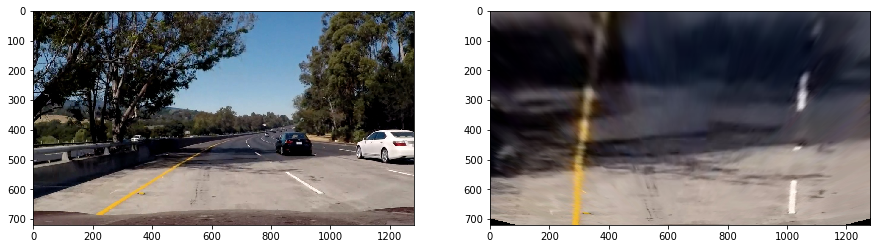

In [6]:
image = cv2.imread('./test_images/test5.jpg')
if image.shape:
    PERSPECTIVE_MATRIX, warped_image, INV_PERSPECTIVE_MATRIX = apply_perspective( image )
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(get_mp_image(image))
    plt.subplot(1,2,2)
    plt.imshow(get_mp_image(warped_image))
    plt.show()

## Color and Gradient Thresholding 

In [7]:
import numpy as np

def saturation_direction_magnitude(s_channel, d_threshold=(0, np.pi / 2), m_threshold=(0, 255), sobel_kernel=3):
    # Taking the gradient in x and y separately
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    m_mask = np.zeros_like(magnitude)
    m_mask[(magnitude >= m_threshold[0]) & (magnitude <= m_threshold[1])] = 1
    
    # Take the absolute value of the x and y gradients and calculate the direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    d_mask = np.zeros_like(direction,dtype=np.uint8)
    # Return this mask as your binary_output image
    d_mask[(direction >= d_threshold[0]) & (direction <= d_threshold[1])] = 1
    
    mask = np.zeros_like(s_channel,dtype=np.uint8)
    mask[((d_mask==1) & (m_mask==1))] = 1
    
    return mask
    

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
def apply_sobel(img, s_thresh=(170, 245), x_thresh=(50, 120), s_d_thresh=(0.7,1.3), s_m_thresh=(50,100)):
    # Convert to HLS color space and separate the H,S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    
    # Sobel x using the grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    x_binary = np.zeros_like(scaled_sobel, dtype=np.uint8)
    x_binary[(scaled_sobel >= x_thresh[0]) & (scaled_sobel <= x_thresh[1])] = 1

    
    # Threshold saturation channel
    s_color = np.zeros_like(s_channel, dtype=np.uint8)
    s_color[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    s_dm = saturation_direction_magnitude(s_channel, s_d_thresh, s_m_thresh)
    
    s_binary = np.zeros_like(s_channel, dtype=np.uint8)
    s_binary[(s_color == 1) | (s_dm == 1)] = 1
    
    # Stack each channel using np.dstack
    color_binary = np.dstack(( np.zeros_like(s_binary, dtype=np.uint8), s_binary, x_binary ))*255
    
    combined_binary = np.zeros_like(x_binary, dtype=np.uint8)
    combined_binary[(s_binary == 1) | (x_binary == 1) ] = 1
    return combined_binary,color_binary

### Test apply_sobel function

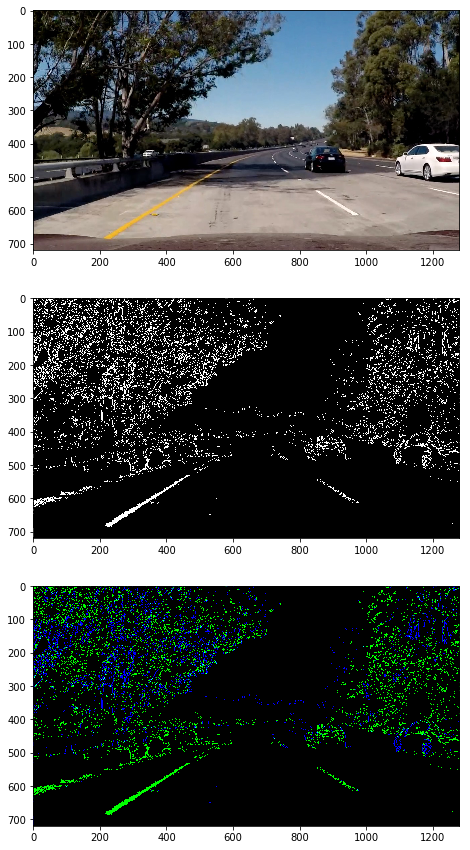

In [9]:
image = cv2.imread('./test_images/test5.jpg')
combined_binary,color = apply_sobel( image )
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
image_b,image_g,image_r = cv2.split(image)
plt.imshow( cv2.merge([image_r,image_g,image_b]) )
plt.subplot(3,1,2)
plt.imshow( combined_binary, cmap='gray' )
plt.subplot(3,1,3)
# sobel for saturation is green
# sobel for x is red
plt.imshow( color )
plt.show()

## Preprocessing of image

In [10]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image( img ):
    if type(PERSPECTIVE_MATRIX) == None or type(DIST_COEFF) == None or type(DIST_MATRIX) == None or type(INV_PERSPECTIVE_MATRIX) == None:
        print("Pipeline won't work as either one of PERSPECTIVE_MATRIX, DIST_COEFF, DIST_MATRIX, INV_PERSPECTIVE_MATRIX is None")
    else:
        '''
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.imshow(get_mp_image(img))
        '''
        undistorted_image = cv2.undistort(img, DIST_MATRIX, DIST_COEFF, None, DIST_MATRIX)
        sobeled_image, sobeled_image_color = apply_sobel( undistorted_image, (180,250), (50,150))
        '''
        plt.subplot(1,3,2)
        plt.imshow(sobeled_image,cmap='gray')
        '''
        warped_image = cv2.warpPerspective(sobeled_image, PERSPECTIVE_MATRIX, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR )
        
        '''
        plt.subplot(1,3,3)
        plt.imshow(warped_image,cmap='gray')
        '''
        return warped_image

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_histogram_peaks( warped_image ):
    #taking histogram for the bottom half of the image
    histogram = np.sum( warped_image[ warped_image.shape[0]//2:,:], axis=0)
    #finding the left & right peaks as these will be starting points
    
    mid = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid])
    rightx_base = np.argmax(histogram[mid:]) + mid
    
    return leftx_base, rightx_base


In [12]:
#visualize the result
def plot_lane_lines( warped_image, output_image, nonzerox, nonzeroy, left_fit, left_lane_indices, right_fit, right_lane_indices):
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #plotting left lane in red
    output_image[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255, 0, 0]
    #plotting right lane in blue
    output_image[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0, 0, 255]

#     plt.figure(figsize=(15,5))
#     plt.imshow(output_image)
    
#     #plotting left & right polynomial curve in yellow
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    

    return output_image

In [13]:
def lane_polynomials( warped_image, leftx_base, rightx_base ):
    #creating an output image
    output_image = np.dstack((warped_image, warped_image, warped_image))*255;
    
    #Let the total height be divided in 9 windows
    nb_win = 9
    window_height = warped_image.shape[0]//nb_win
    
    #Identifying the postions of all non-zero pixels in the image
    nz = warped_image.nonzero()
    nz_y = np.array(nz[0])
    nz_x = np.array(nz[1])
    
    #current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #setting width of window
    window_width = 100
    
    #minimum pixel to be found to recenter the window
    minpix = 50
    
    #initializing empty lists to receive left and right lane pixels
    left_lane_indices = []
    right_lane_indices = []
    
    #iteration using windows along height
    for window in range(nb_win):
        #calculating window boundaries
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - window_width
        win_xleft_high = leftx_current + window_width
        win_xright_low = rightx_current - window_width
        win_xright_high = rightx_current + window_width
        '''
        #Draw the windows on the visualization image
        cv2.rectangle(output_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(output_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        '''
        #Identify the nonzero pixels in x and y within the window
        reqd_left_indices =  ((nz_y >= win_y_low) & (nz_y < win_y_high) & (nz_x >= win_xleft_low) &  (nz_x < win_xleft_high)).nonzero()[0]
        reqd_right_indices = ((nz_y >= win_y_low) & (nz_y < win_y_high) & (nz_x >= win_xright_low) &  (nz_x < win_xright_high)).nonzero()[0]
        
        #Appending the indices to the lists
        left_lane_indices.append( reqd_left_indices )
        right_lane_indices.append( reqd_right_indices )
        
        #if pixels currently found are greater than 'minpix', the we should re-center the window
        if len(reqd_left_indices) > minpix:
            leftx_current = np.int(np.mean(nz_x[reqd_left_indices], axis=0))
        if len(reqd_right_indices) > minpix:        
            rightx_current = np.int(np.mean(nz_x[reqd_right_indices], axis=0))
    
    # Concatenating the arrays of indices
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    # Extract left and right line pixel positions
    leftx = nz_x[left_lane_indices]
    lefty = nz_y[left_lane_indices] 
    rightx = nz_x[right_lane_indices]
    righty = nz_y[right_lane_indices] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    output_image = plot_lane_lines( warped_image, output_image, nz_x, nz_y, left_fit, left_lane_indices, right_fit, right_lane_indices)
    
    return left_fit, right_fit, output_image
    
    

In [14]:
def subsequent_lane_polynomials( warped_image, left_fit, right_fit ):
    #creating an output image
    output_image = np.dstack((warped_image, warped_image, warped_image))*255;
    
    nz = warped_image.nonzero()
    nz_y = np.array(nz[0])
    nz_x = np.array(nz[1])
    window_width = 100
    left_lane_indices = ((nz_x > (left_fit[0]*(nz_y**2) + left_fit[1]*nz_y + left_fit[2] - window_width)) & (nz_x < (left_fit[0]*(nz_y**2) + left_fit[1]*nz_y + left_fit[2] + window_width)))

    right_lane_indices = ((nonzerox > (right_fit[0]*(nz_y**2) + right_fit[1]*nz_y + right_fit[2] - window_width)) & (nz_x < (right_fit[0]*(nz_y**2) + right_fit[1]*n_zy + right_fit[2] + window_width)))

    # Again, extract left and right line pixel positions
    leftx = nz_x[left_lane_indices]
    lefty = nz_y[left_lane_indices] 
    rightx = nz_x[right_lane_indices]
    righty = nz_y[right_lane_indices]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output_image = plot_lane_lines( warped_image, output_image, nz_x, nz_y, left_fit, left_lane_indices, right_fit, right_lane_indices)
    

In [15]:
def place_back_calculated_path(warped_image,left_fit,right_fit):
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack((left_fitx, ploty)))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack((right_fitx, ploty))))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (INV_PERSPECTIVE_MATRIX)
    newwarp = cv2.warpPerspective(color_warp, INV_PERSPECTIVE_MATRIX, (warped_image.shape[1], warped_image.shape[0]))
    #plt.imshow(newwarp)
    return newwarp

In [16]:
def weighted_img(initial_img, img, α=0.6, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [17]:
def radius_of_curvature( left_fit,right_fit ):
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2

## Testing of detection of lane-line polynomial 

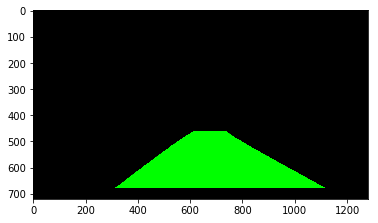

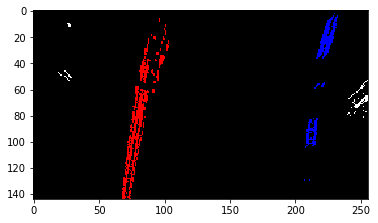

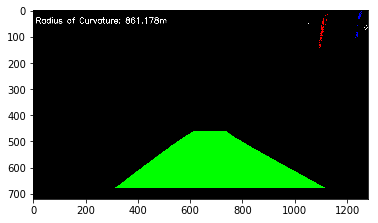

In [18]:
import cv2
def test_lane_line_polynomial( original, pp_image ):
    left_x_base,right_x_base = get_histogram_peaks( pp_image )
    left_fit, right_fit, warped_image = lane_polynomials( pp_image, left_x_base, right_x_base )
    output_image = place_back_calculated_path(pp_image,left_fit, right_fit)
    RoC = radius_of_curvature(left_fit,right_fit)
    return output_image,warped_image, RoC

image = cv2.imread('./test_images/test6.jpg')
preprocessed_image = preprocess_image( image )
resultant_img,_,RoC = test_lane_line_polynomial(image, preprocessed_image)
plt.imshow( resultant_img )
plt.figure()
_ = cv2.resize(_, (0,0), fx=0.2, fy=0.2) 
plt.imshow( _ )
plt.figure()
x_offset=np.int(resultant_img.shape[1]*0.8)
y_offset=0
resultant_img[y_offset:y_offset+_.shape[0], x_offset:x_offset+_.shape[1]] = _
cv2.putText( resultant_img, 'Radius of Curvature: {:0.3f}m'.format(RoC), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA )
plt.imshow( resultant_img )


### Apply on video 

In [19]:
from moviepy.editor import VideoFileClip

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_copy = np.copy(image)
    image = get_mp_image( image )
    pp_image = preprocess_image( image )
    result,warped_lane_lines,rc = test_lane_line_polynomial(image, pp_image)
    
    merged = weighted_img( image_copy, result,1, 0.5)
    
    # Resize and add warped lane-lines image to top right corner
    warped_lane_lines = cv2.resize(warped_lane_lines, (0,0), fx=0.3, fy=0.3)
    x_offset=np.int(merged.shape[1]*0.7)
    y_offset=0
    merged[y_offset:y_offset + warped_lane_lines.shape[0], x_offset:x_offset + warped_lane_lines.shape[1]] = warped_lane_lines

    r_o_c = 'Radius of Curvature: {:0.3f}m'.format(rc)
    if rc <= 1000:
        font_color = (255,255,255)
    elif rc > 1000 and rc <=10000:
        font_color = (255,0,0)
    else:
        font_color = (0,0,255)
    cv2.putText( merged, r_o_c,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,font_color,1,cv2.LINE_AA )
    return merged

In [20]:
def make_video():
    output_video = 'output_video/project_video.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("project_video.mp4").subclip(35,50)
    lane_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(output_video, audio=False)

In [21]:
make_video()

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 375/376 [01:49<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

Wall time: 1min 51s
